In [32]:
import sys
import os
sys.path.append('..')

import matplotlib.pyplot as plt
import xarray as xr
import pickle
import numpy as np

from numpy.lib.stride_tricks import sliding_window_view

In [33]:
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC"
rapid_depth = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'moc_vertical.nc'))

rapid_depth

<xarray.Dataset>
Dimensions:              (time: 13057, depth: 307)
Coordinates:
  * time                 (time) datetime64[ns] 2004-04-02 ... 2022-02-15
  * depth                (depth) float64 0.0 19.87 39.74 ... 5.976e+03 5.995e+03
Data variables:
    stream_function_mar  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

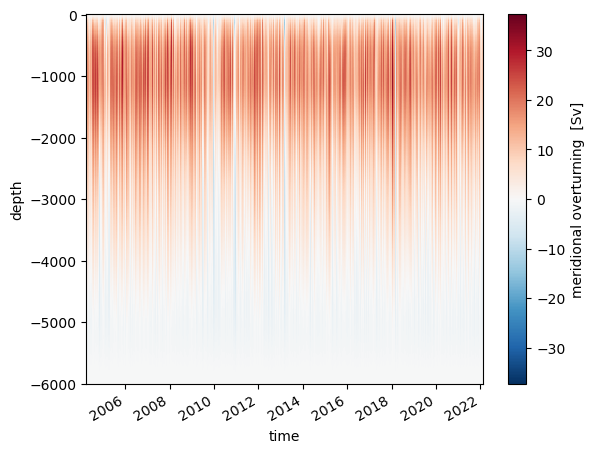

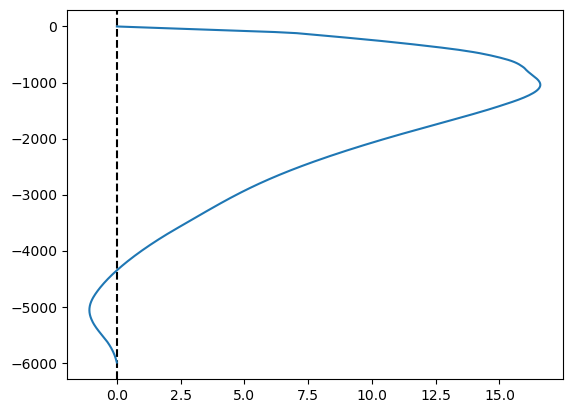

In [34]:
rapid_flipped = rapid_depth.stream_function_mar.assign_coords({'depth' : -1 * rapid_depth.depth})

rapid_flipped.plot()
plt.show()

plt.axvline(0, color = 'black', linestyle = '--')
plt.plot(rapid_flipped.mean('time'), rapid_flipped.depth)
plt.show()

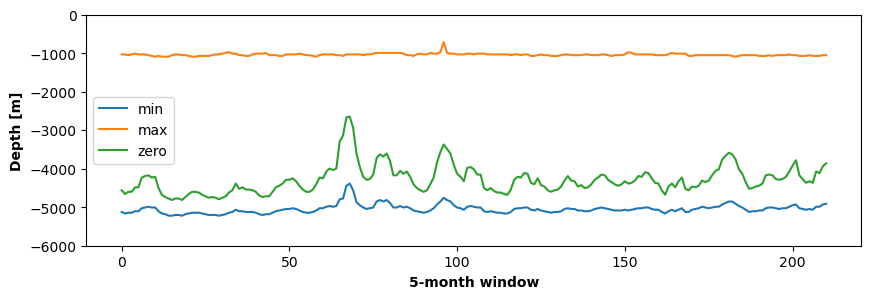

In [153]:
def min_max_zero(arr):
    arr = arr.copy()
    
    idx_min = np.nanargmin(arr)
    idx_max = np.nanargmax(arr)

    # ignore the bottom/top depths, which are always 0
    arr[-10 : ] = np.nan 
    arr[ : 10] = np.nan
    idx_zero = np.nanargmin(np.abs(arr))
    
    return idx_min, idx_max, idx_zero

# Downsample to monthly means
rapid_monthly = rapid_flipped.resample({'time' : 'M'}).mean()

# Take a 5-month window mean for streamfunction values at each depth & time
rapid_window_mean = np.nanmean(sliding_window_view(rapid_monthly.values, window_shape = 5, axis = 1), axis = 2)

# Extract the minimum, maximum, and (intermediate) zero streamfunction depths
idx_min = np.nanargmin(rapid_window_mean, axis = 0)
idx_max = np.nanargmax(rapid_window_mean, axis = 0)

#  ignore the bottom/top depths, which are always 0
rapid_window_mean[-10 : ] = np.nan 
rapid_window_mean[ : 10] = np.nan
idx_zero = np.nanargmin(np.abs(rapid_window_mean), axis = 0)

depths = rapid_flipped.depth.values
min_depths = depths[idx_min]
min_depths[min_depths > -2000] = np.nan
max_depths = depths[idx_max]
zero_depths = depths[idx_zero]

# Plot these over time--not quite sure how to interpret time dimension because of windows...
plt.figure(figsize = (10, 3))

plt.plot(min_depths, label = 'min')
plt.plot(max_depths, label = 'max')
plt.plot(zero_depths, label = 'zero')

plt.ylim(-6000, 0)

plt.ylabel('Depth [m]', weight = 'bold')
plt.xlabel('5-month window', weight = 'bold')

plt.legend();

In [35]:
# This temp and salinity data may not be useful for calculating potential density since it's
#   aggregated over longitudes...
rapid_temp_sal = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'ts_gridded.nc'))
rapid_temp_sal

<xarray.Dataset>
Dimensions:          (time: 13057, depth: 242)
Coordinates:
  * time             (time) datetime64[ns] 2004-04-02 ... 2022-02-15
Dimensions without coordinates: depth
Data variables: (12/19)
    pressure         (depth) float64 ...
    TG_west          (depth, time) float64 ...
    SG_west          (depth, time) float64 ...
    TG_wb3           (depth, time) float64 ...
    SG_wb3           (depth, time) float64 ...
    TG_east          (depth, time) float64 ...
    ...               ...
    TG_east_flag     (depth, time) float64 ...
    SG_east_flag     (depth, time) float64 ...
    TG_marwest_flag  (depth, time) float64 ...
    SG_marwest_flag  (depth, time) float64 ...
    TG_mareast_flag  (depth, time) float64 ...
    SG_mareast_flag  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

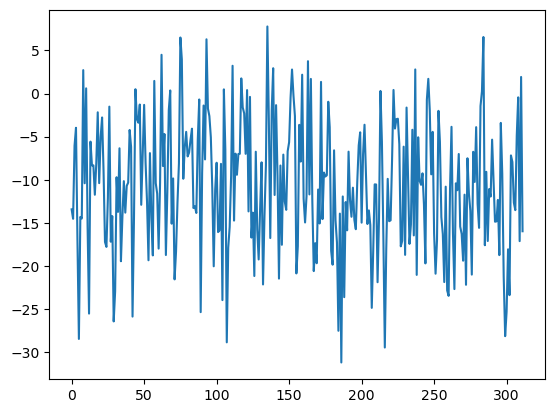

In [40]:
lat = '60S'
moc_fp = f"{data_home}/ecco_data_minimal/{lat}_moc_density.pickle"

with open(moc_fp, 'rb') as f:
    moc = pickle.load(f)

moc = moc[1, : ]
plt.plot(moc)